# Spring


In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

from SpringProblem.physics_utils import DampenSpringSystem
from SpringProblem.model import MLP
from SpringProblem.dataset import PhysicsDataset

In [2]:
def get_state_dict(checkpoint_dir):
    checkpoint_files = [
        f for f in os.listdir(checkpoint_dir) 
        if f.startswith("model_ckpt_") and f.endswith(".pth")
    ]
    checkpoint_numbers = [
        int(f.split("_")[-1].split(".")[0]) for f in checkpoint_files
    ]
    latest_checkpoint = max(checkpoint_numbers)

    # Construct the path to the latest checkpoint file
    latest_checkpoint_path = os.path.join(checkpoint_dir, f"model_ckpt_{latest_checkpoint}.pth")

    # Load the latest checkpoint
    state_dict = torch.load(latest_checkpoint_path)
    return state_dict

In [3]:
device = "cuda"

mass = 1
mu = 1
k = [10]

num_epoch = 10000
t_max = 6
M = 60
alpha = 1

In [4]:
log_dir=r"D:\Deep learning projects\PINN\final_results\spring\extrapolation"

system = DampenSpringSystem(1,0,mass, k[0], mu)
physics_model = MLP(system,1,1,[64,64,64])
checkpoint_dir = os.path.join(log_dir,"pinn","checkpoints")
state_dict = get_state_dict(checkpoint_dir)
physics_model.load_state_dict(state_dict)

baseline = MLP(system,1,1,[64,64,64])
checkpoint_dir = os.path.join(log_dir,"baseline","checkpoints")
state_dict = get_state_dict(checkpoint_dir)
baseline.load_state_dict(state_dict)

truth_data = system.generate_noisy_datapoints(0,t_max,256,0.005,False)
train_data = system.generate_noisy_datapoints(0,2.5,10,0.005,True)



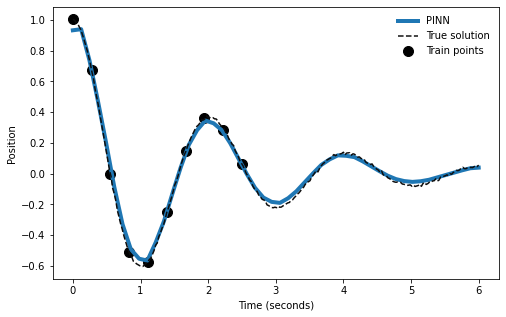

In [9]:
with torch.no_grad():
    physics_model.eval().to("cpu")
    test_t = torch.linspace(0, t_max, 50)
    test_t = test_t.unsqueeze(1)
    test_x_preds = physics_model(test_t)
    baseline_x_preds = baseline(test_t)

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Space-inspired colors
    ax.plot(test_t, test_x_preds, linewidth=4, label="PINN", c="#1f77b4")  # Deep blue for PINN
    # ax.plot(test_t, baseline_x_preds, linewidth=4, label="Baseline", c="#6a0dad")  # Nebula purple for baseline
    ax.plot(truth_data["t"], truth_data["x"], linestyle="--", label="True solution", c="#0e0e0e")  # White for truth
    ax.scatter(train_data["t"], train_data["x"], s=100, label="Train points", c="#000000")  # Star-like yellow for train points

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Position")
    legend = ax.legend(
        loc="upper right", fontsize=10, frameon=False, facecolor="black", edgecolor="white"
    )
    # ax.set_axis_off()

    os.makedirs(os.path.join(log_dir, "figures"), exist_ok=True)
    fig.savefig(os.path.join(log_dir, "figures", "true_sol_damped_spring.png"))


# Bodies

In [8]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from BodiesProblem.physics_utils_new import ThreeBodySystem, TwoBodySystem, OneBodySystem
from BodiesProblem.utils import save_gif, save_plot
from BodiesProblem.models_new import GravitationalBodiesMLP
from BodiesProblem.siren_utils import GravitationalBodiesSIREN
from BodiesProblem.dataset import PhysicsDataset

In [77]:
device = "cuda"
print("Training on GPU: ", torch.cuda.is_available())
torch.manual_seed(42)
np.random.seed(42)
# Define system parameters
mass = [1,0.75] #[0.0001, 1]
G = 1
num_epoch = 100000
t_max = 5
M = 500
alpha = 0.001

log_dir=r"D:\Deep learning projects\PINN\final_results\gravity\interpolation"

r1 = np.array([0.5, 0])
r2 = np.array([-0.5, 0.5])



v1 = np.array([-0.2, 1])
v2 = np.array([0, 0.5])


system = TwoBodySystem(r1, r2, v1, v2, (0, t_max), mass, G)
test_t = torch.linspace(0, t_max, M).unsqueeze(1).to(device)
train_data = system.generate_noisy_datapoints(0, t_max, 12, 0.0005)
val_data = system.generate_noisy_datapoints(0, t_max, 1000, 0.0005)

# Initialize model, optimizer, and TensorBoard writer
physics_model = GravitationalBodiesSIREN(system,
                                        num_predict_bodies=1,
                                        input_size=1,
                                        output_size=4,
                                        hidden_size=64,
                                        hidden_layers=3,
                                        omega_0=3,
                                        alpha_vel=alpha,
                                        alpha_eq=alpha,
                                        num_physics_points=M,
                                        device = device)



checkpoint_dir = os.path.join(log_dir,"pinn","checkpoints")
state_dict = get_state_dict(checkpoint_dir)
physics_model.load_state_dict(state_dict)

baseline = GravitationalBodiesSIREN(system,
                                        num_predict_bodies=1,
                                        input_size=1,
                                        output_size=4,
                                        hidden_size=64,
                                        hidden_layers=3,
                                        omega_0=3,
                                        alpha_vel=alpha,
                                        alpha_eq=alpha,
                                        num_physics_points=M,
                                        device = device)
checkpoint_dir = os.path.join(log_dir,"baseline","checkpoints")
state_dict = get_state_dict(checkpoint_dir)
baseline.load_state_dict(state_dict)

Training on GPU:  True
torch.Size([255, 1])
torch.Size([255, 1])


<All keys matched successfully>

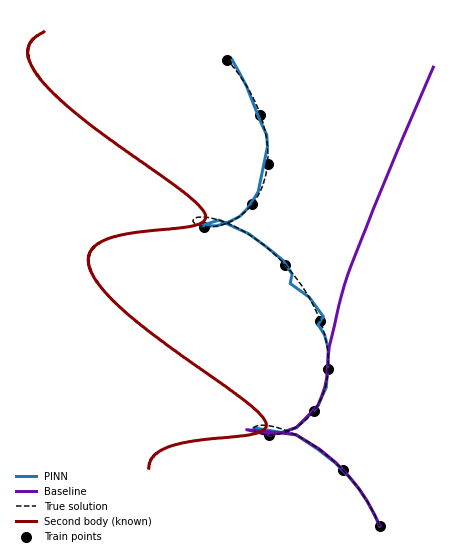

In [73]:
with torch.no_grad():
    physics_model.eval().to("cpu")
    baseline.eval().to("cpu")
    test_t = torch.linspace(0, t_max, 50)
    test_t = test_t.unsqueeze(1)
    test_preds = physics_model(test_t)[0]
    baseline_preds = baseline(test_t)[0]
    fig, ax = plt.subplots(1, 1, figsize=(8,10))

    # Space-inspired colors
    ax.plot(test_preds[:,0], test_preds[:,1], linewidth=3, label="PINN", c="#1f77b4")  # Deep blue for PINN
    ax.plot(baseline_preds[:,0], baseline_preds[:,1], linewidth=3, label="Baseline", c="#6a0dad")  # Nebula purple for baseline
    ax.plot(val_data["x"][0,:], val_data["x"][1,:], linestyle="--", label="True solution", c="#0e0e0e")  # White for truth
    ax.plot(val_data["x"][2,:], val_data["x"][3,:], linewidth=3, label="Second body (known)", c="#8b0000")  # White for truth
    ax.scatter(train_data["x"][0,:], train_data["x"][1,:], s=100,label="Train points", c="#000000")  # Star-like yellow for train points
    legend = ax.legend(
        loc="lower left", fontsize=10, frameon=False, facecolor="black", edgecolor="white"
    )
    ax.set_axis_off()

    os.makedirs(os.path.join(log_dir, "figures"), exist_ok=True)
    fig.savefig(os.path.join(log_dir, "figures", "end_prediction.png"))

In [65]:
print(physics_model.physics_times.shape)

torch.Size([255, 1])


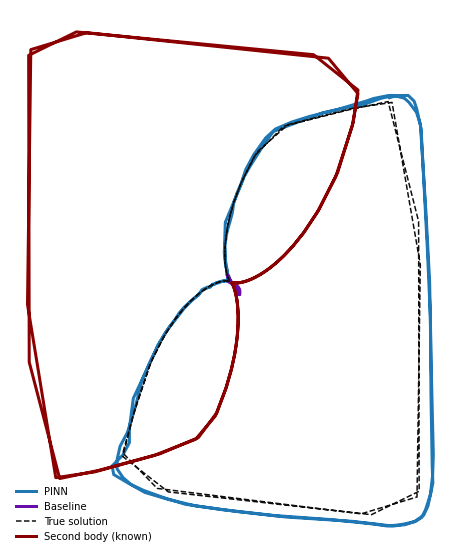

In [78]:
import os
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    physics_model.eval().to("cpu")
    baseline.eval().to("cpu")
    test_t = physics_model.physics_times.to("cpu")
    test_preds = physics_model(test_t)[0]
    test_preds_a = torch.gradient(test_preds[:, 2:], spacing=(test_t.squeeze(1),), dim=0)[0]

    true_a_1 = torch.gradient(
        torch.tensor(val_data["xdot"].T)[:, :2],
        spacing=(torch.tensor(val_data["t"]),),
        dim=0
    )[0]
    true_a_2 = torch.gradient(
        torch.tensor(val_data["xdot"].T)[:, 2:],
        spacing=(torch.tensor(val_data["t"]),),
        dim=0
    )[0]
    baseline_preds = baseline(test_t)[0]
    baseline_preds_a = torch.gradient(baseline_preds[:, 2:], spacing=(test_t.squeeze(1),), dim=0)[0]

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))

    # Set symlog scale
    x_threshold = 50  # Linear region threshold for x-axis
    y_threshold = 50  # Linear region threshold for y-axis
    ax.set_xscale("symlog", linthresh=x_threshold)
    ax.set_yscale("symlog", linthresh=y_threshold)

    # Plot data
    ax.plot(test_preds_a[:, 0], test_preds_a[:, 1], linewidth=3, label="PINN", c="#1f77b4")
    ax.plot(baseline_preds_a[:, 0], baseline_preds_a[:, 1], linewidth=3, label="Baseline", c="#6a0dad")
    ax.plot(true_a_1[:, 0], true_a_1[:, 1], linestyle="--", label="True solution", c="#0e0e0e")
    ax.plot(true_a_2[:, 0], true_a_2[:, 1], linewidth=3, label="Second body (known)", c="#8b0000")

    # Legend customization
    legend = ax.legend(
        loc="lower left", fontsize=10, frameon=False, facecolor="black", edgecolor="white"
    )

    # Turn off axis for a clean look
    ax.set_axis_off()

    # Save the figure
    os.makedirs(os.path.join(log_dir, "figures"), exist_ok=True)
    fig.savefig(os.path.join(log_dir, "figures", "end_prediction_a.png"))
